# 0.0 Imports

In [167]:
import seaborn           as sns
import matplotlib.pyplot as plt
import pandas            as pd
import numpy             as np
import inflection

from IPython.display      import Image
from IPython.core.display import HTML

from fast_ml.model_development import train_valid_test_split

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import pickle

# feature selection
from boruta                    import BorutaPy
from sklearn.feature_selection import RFECV
from yellowbrick.features      import Rank1D

# modeling
from sklearn.ensemble    import RandomForestClassifier
from sklearn.ensemble    import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn             import base
from sklearn             import linear_model as lm
from sklearn             import neighbors    as nh
import                          xgboost      as xgb
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.dummy           import DummyClassifier

# model selection
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

#metrics
import scikitplot as skplt
from   sklearn.metrics import precision_score, recall_score, accuracy_score, balanced_accuracy_score
import sklearn.metrics   as m

# tuning
import optuna as op

## 0.1 Helper functions

In [76]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:85% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
jupyter_settings()

In [6]:
def get_summary(numerical_attributes):
    
    # Central Tendency - mean, meadina 
    ct1 = pd.DataFrame( numerical_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( numerical_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( numerical_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( numerical_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( numerical_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( numerical_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( numerical_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( numerical_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [131]:
def ml_cv_results(model_name, model, x, y):
    
    '''initial'''
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    balanced_accuracies = []
    precisions = []
    recalls = []
    f1s = []
    kappas = []
    
    
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
       
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
    
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        balanced_accuracies.append(m.balanced_accuracy_score(y_test, y_pred))
        precisions.append(m.precision_score(y_test, y_pred))
        recalls.append(m.recall_score(y_test, y_pred))
        f1s.append(m.f1_score(y_test, y_pred))
        kappas.append(m.cohen_kappa_score(y_test, y_pred))
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(balanced_accuracies), 3), np.round(np.std(balanced_accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    kappa_mean, kappa_std = np.round(np.mean(kappas), 3), np.round(np.std(kappas), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Balanced Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std),
                        "Kappa": "{} +/- {}".format(kappa_mean, kappa_std)},
                       index=[model_name])

In [8]:
def f1_score_metric(model_name, y_test, pred):
    return pd.DataFrame({'Model Name': model_name,
                        'F1 Score': f1_score(pred,y_test).round(3)}, index=[0])

In [9]:
#suppress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [10]:
def categorical_metrics(data, col):
    """
    Shows the the absolute and percent values in categorical variables.

    Args:
        data ([object]): Insert all categorical attributes in the dataset

    Returns:
        [dataframe]: A dataframe with absolute and percent values
    """
    


    return pd.DataFrame({'absolute': data[col].value_counts(), 'percent %': data[col].value_counts(normalize = True) * 100 })

In [121]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = m.balanced_accuracy_score(y_true, y_pred)
    precision = m.precision_score(y_true, y_pred)
    recall = m.recall_score(y_true, y_pred)
    f1 = m.f1_score(y_true, y_pred)
    kappa = m.cohen_kappa_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'Kappa': np.round(kappa, 3)}, index=[model_name])

## 0.2 Load Data

In [11]:
df_raw = pd.read_csv('../data/raw/churn.csv')
df_raw.drop('RowNumber', axis=1, inplace=True)

# 1.0 Data Description

In [12]:
df1 = df_raw.copy()
df1.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1.1 Data dimension

In [13]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 10000
Number of columns: 13


## 1.2 Rename Columns

In [14]:
cols_old = df1.columns.to_list()

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new
df1.columns

Index(['customer_id', 'surname', 'credit_score', 'geography', 'gender', 'age',
       'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

## 1.3 Data Types

In [15]:
df1.dtypes

customer_id           int64
surname              object
credit_score          int64
geography            object
gender               object
age                   int64
tenure                int64
balance             float64
num_of_products       int64
has_cr_card           int64
is_active_member      int64
estimated_salary    float64
exited                int64
dtype: object

## 1.4 Check NAs

In [16]:
df1.isna().sum()

customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 1.5 Descriptive Statistics

In [17]:
num_attributes = df1.select_dtypes( include = [ 'int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [18]:
get_summary(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,customer_id,15565701.00,15815690.00,249989.00,15690940.57,15690738.00,71932.59,0.00,-1.20
1,credit_score,350.00,850.00,500.00,650.53,652.00,96.65,-0.07,-0.43
2,age,18.00,92.00,74.00,38.92,37.00,10.49,1.01,1.40
3,tenure,0.00,10.00,10.00,5.01,5.00,2.89,0.01,-1.17
4,balance,0.00,250898.09,250898.09,76485.89,97198.54,62394.29,-0.14,-1.49
5,num_of_products,1.00,4.00,3.00,1.53,1.00,0.58,0.75,0.58
6,has_cr_card,0.00,1.00,1.00,0.71,1.00,0.46,-0.90,-1.19
7,is_active_member,0.00,1.00,1.00,0.52,1.00,0.50,-0.06,-2.00
8,estimated_salary,11.58,199992.48,199980.90,100090.24,100193.91,57507.62,0.00,-1.18
9,exited,0.00,1.00,1.00,0.20,0.00,0.40,1.47,0.17


In [19]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

surname      2932
geography       3
gender          2
dtype: int64

# 2.0 Feature Engeenering

In [20]:
df2 = df1.copy()

In [21]:
# get feature of bined ages

# 3.0 Feature Filtering

In [22]:
df3 = df2.copy()

In [23]:
df3.drop(['customer_id','surname'], axis=1, inplace=True)

In [24]:
df3.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 4.0 Exploratory Data Analysis

In [25]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Target Variable

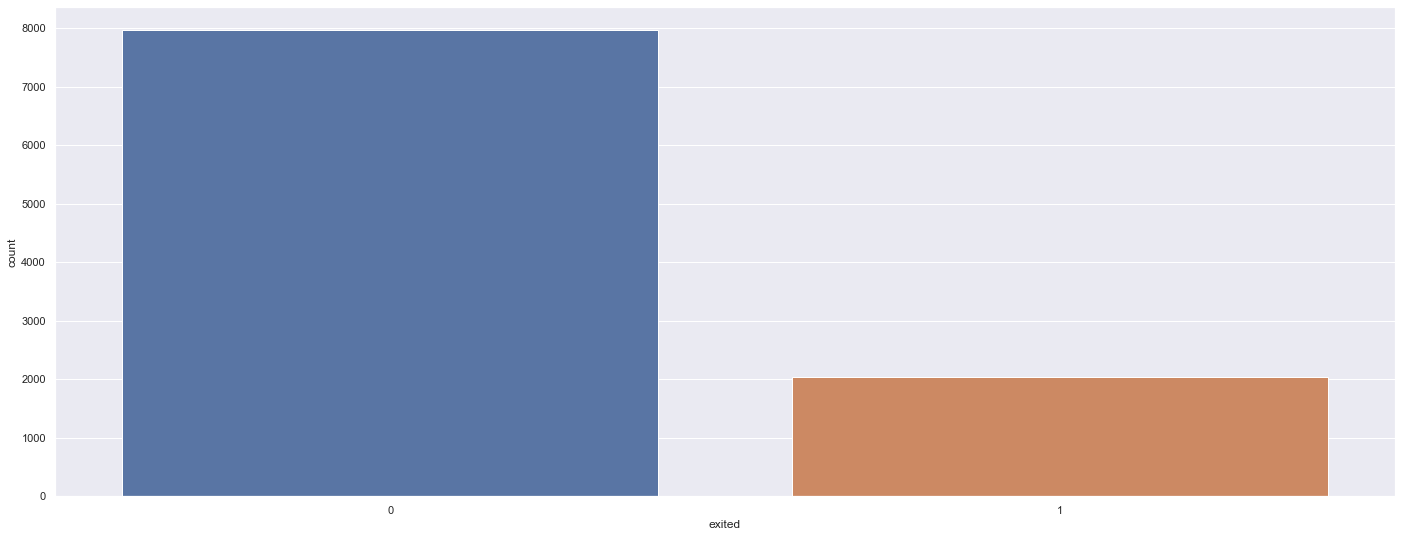

In [26]:
sns.countplot(x='exited', data=df4);

In [27]:
categorical_metrics(df4, 'exited')

,absolute,percent %
0,7963,79.63
1,2037,20.37


### 4.1.2 Numerical Variables

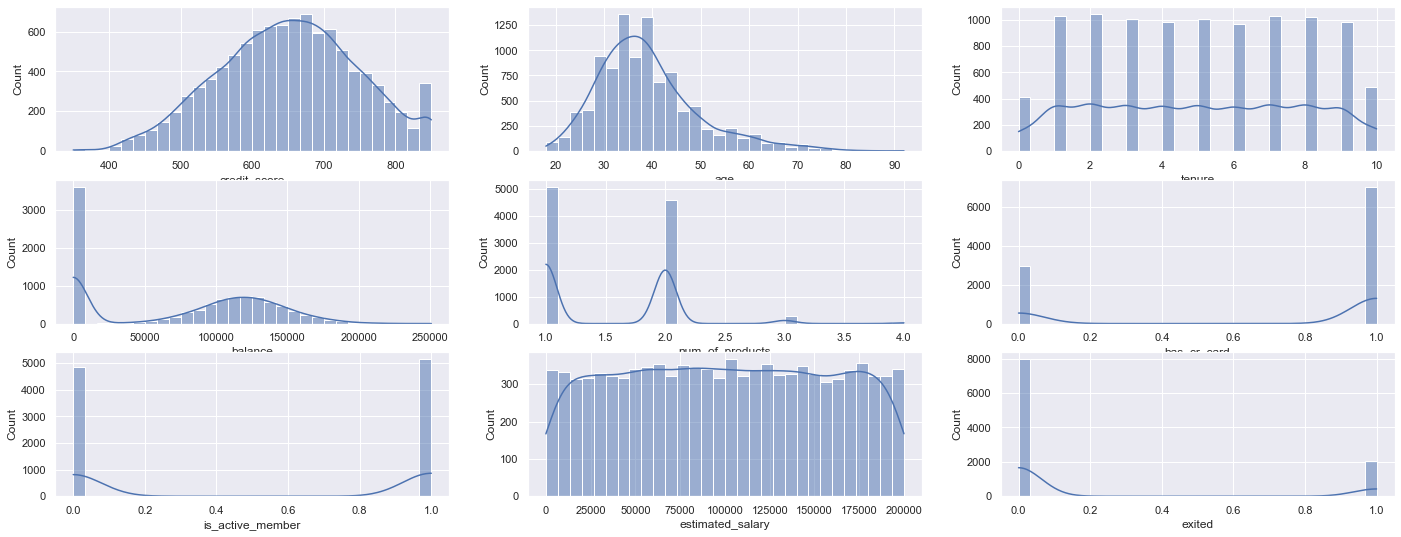

In [28]:
num_attributes = df4.select_dtypes(exclude='object')
columns = num_attributes.columns;
j = 1

for i in columns:
    plt.subplot(3, 3, j)
    sns.histplot(x=i, data=df4, kde=True, bins=30);
    
    j += 1

### 4.1.3 Categorical Variables

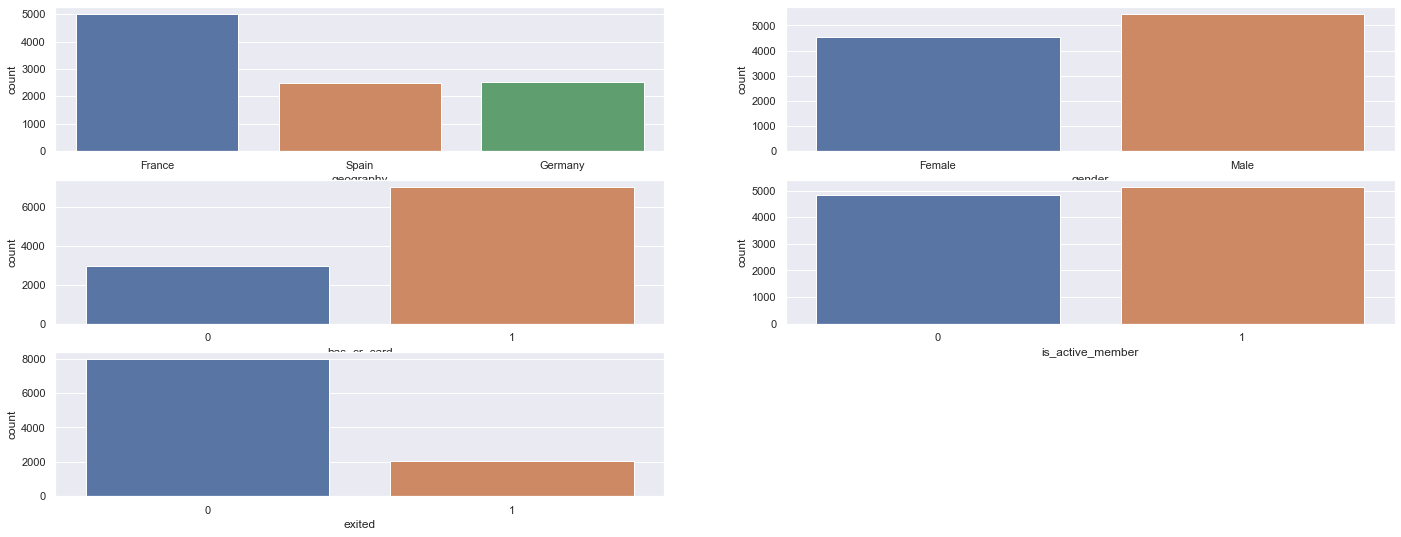

In [29]:
columns = ['geography', 'gender', 'has_cr_card', 'is_active_member', 'exited']
j = 1

for i in columns:
    plt.subplot(3, 2, j)
    sns.countplot(x=i, data=df4);
    j += 1

## 4.2 Multivariate Analysis

<AxesSubplot:>

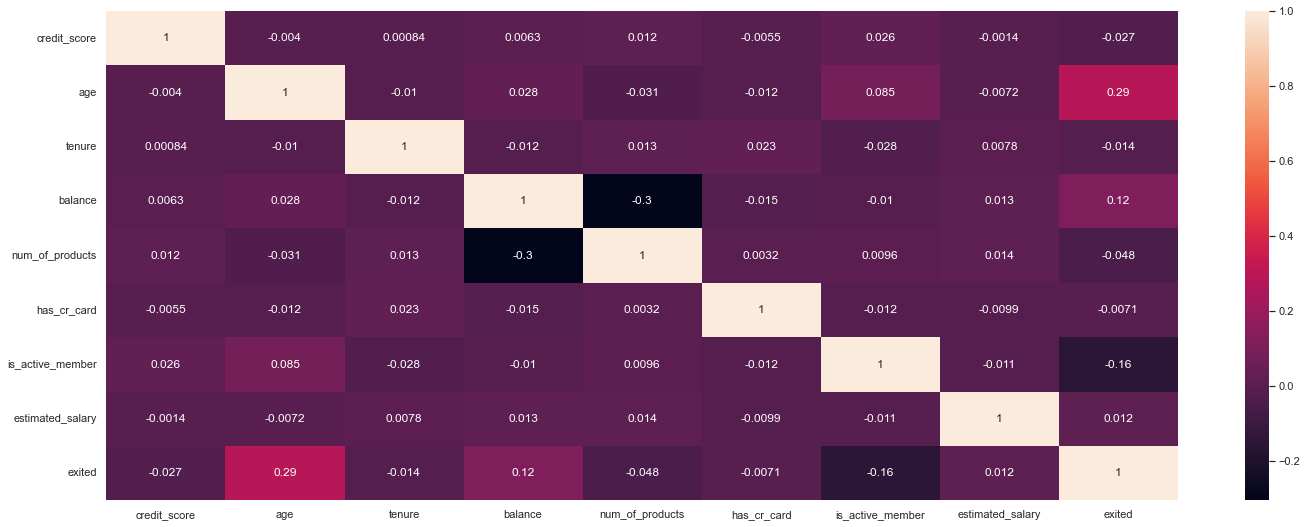

In [30]:
num_attr = df4.select_dtypes( include = ['int64' , 'float64'] )
sns.heatmap( num_attr.corr(method='pearson'), annot=True)

## 4.3 Bivariate Analysis

H1: People who receive a salary below the average salary are more likely to Churn
H2: People with less products purchased are more likely to Churn
H3: Younger people are more likely to Churn
H4: Credit card customers are more active.
H5: People who don't have a credit card are more likely to Churn

### H1: People who receive a salary below the average salary are more likely to Churn

In [31]:
#False, they have relatively the same median salary.

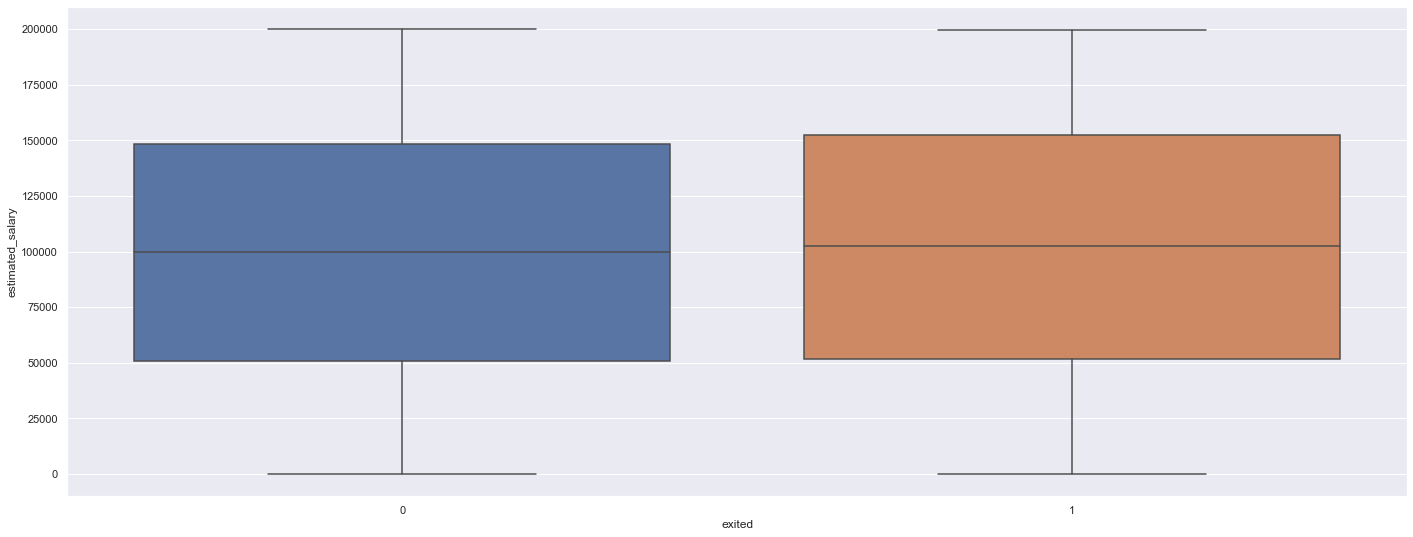

In [32]:
sns.boxplot(x='exited', y='estimated_salary', data=df4);

### H2: People with less products purchased are more likely to Churn

In [33]:
df4.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


,exited,num_of_products
0,0,1.54
1,1,1.48


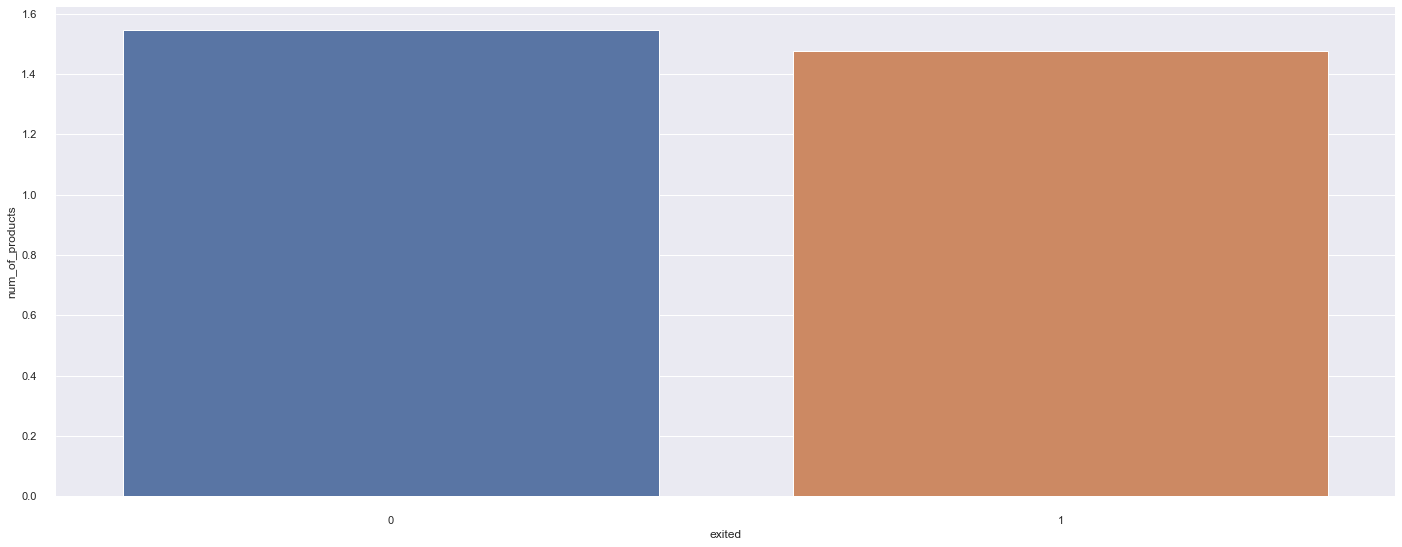

In [34]:
aux = df4[['num_of_products', 'exited']].groupby( 'exited' ).mean().reset_index()
sns.barplot( x='exited', y='num_of_products', data=aux )
sns.despine(offset = 10, trim = True);

aux.head()

### H3: Younger people are more likely to Churn

In [35]:
df4[['exited', 'age']].groupby(['exited']).mean().reset_index()

,exited,age
0,0,37.41
1,1,44.84


<AxesSubplot:xlabel='age', ylabel='Count'>

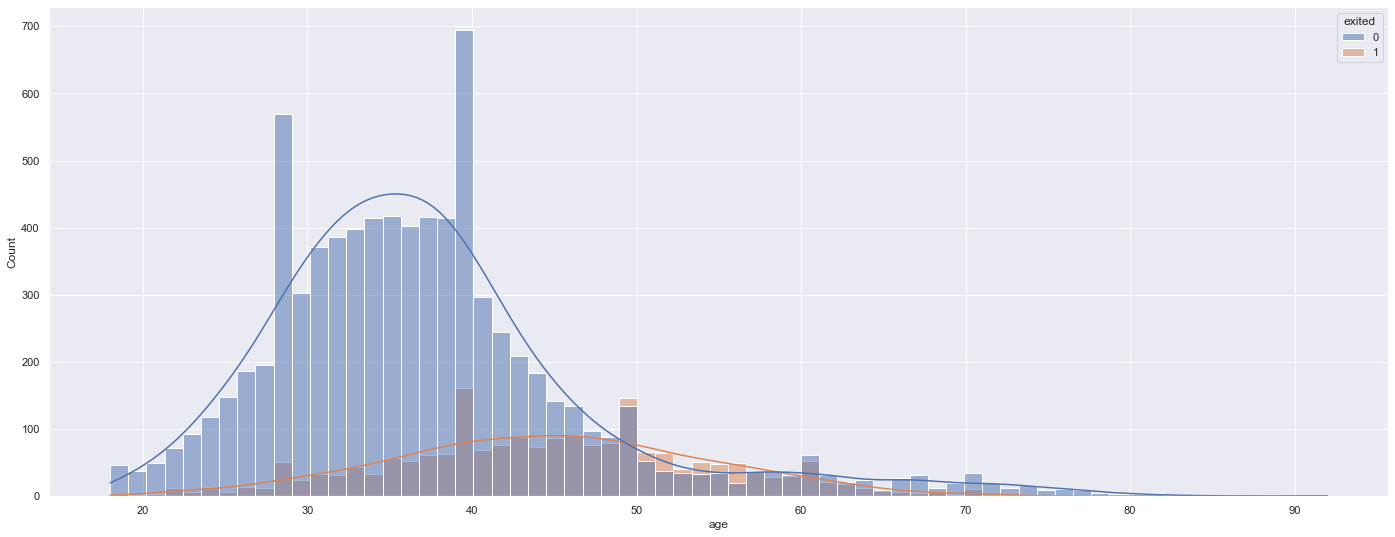

In [36]:
sns.histplot(x='age', data=df4, hue='exited', kde=True)

### H4: Credit card customers are more active.

<AxesSubplot:xlabel='has_cr_card', ylabel='count'>

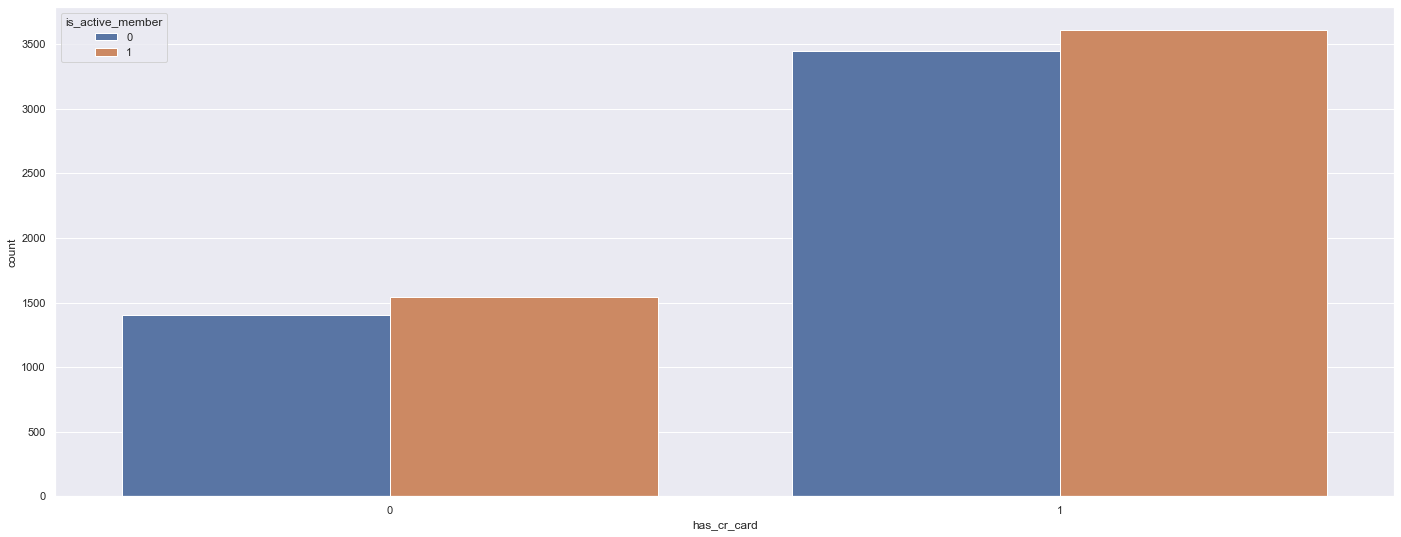

In [37]:
sns.countplot(x='has_cr_card', hue='is_active_member', data=df4)

### H5: People who don't have a credit card are more likely to Churn

<AxesSubplot:xlabel='has_cr_card', ylabel='count'>

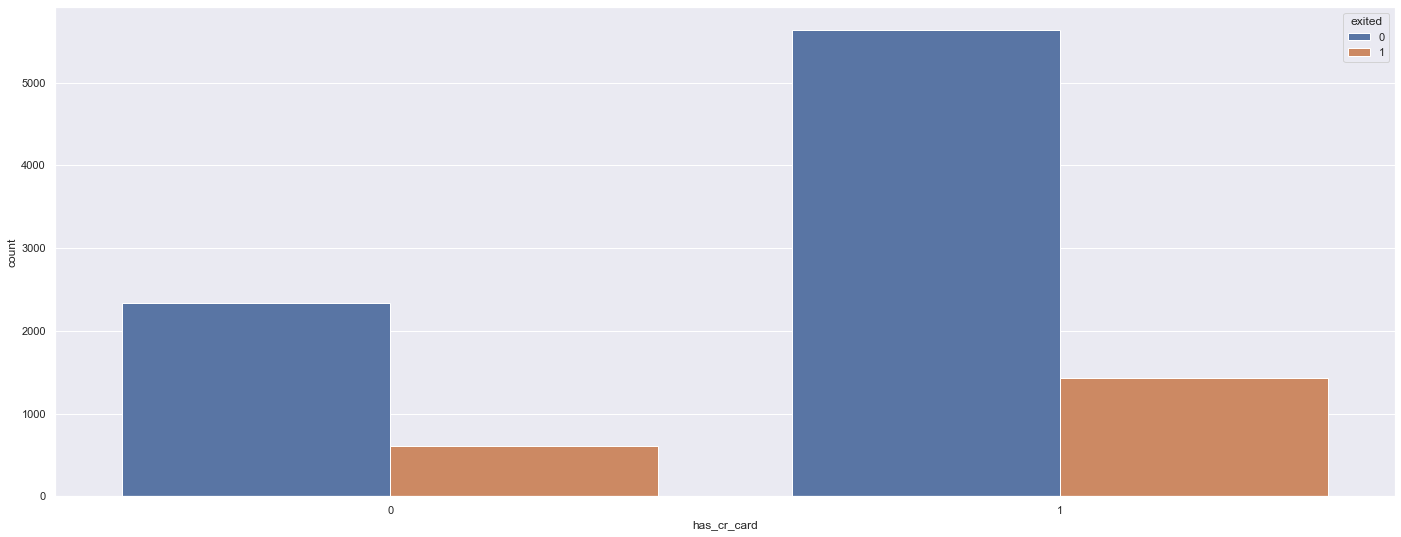

In [38]:
sns.countplot(x='has_cr_card', hue='exited', data=df4)

# 5.0 Data Preparation

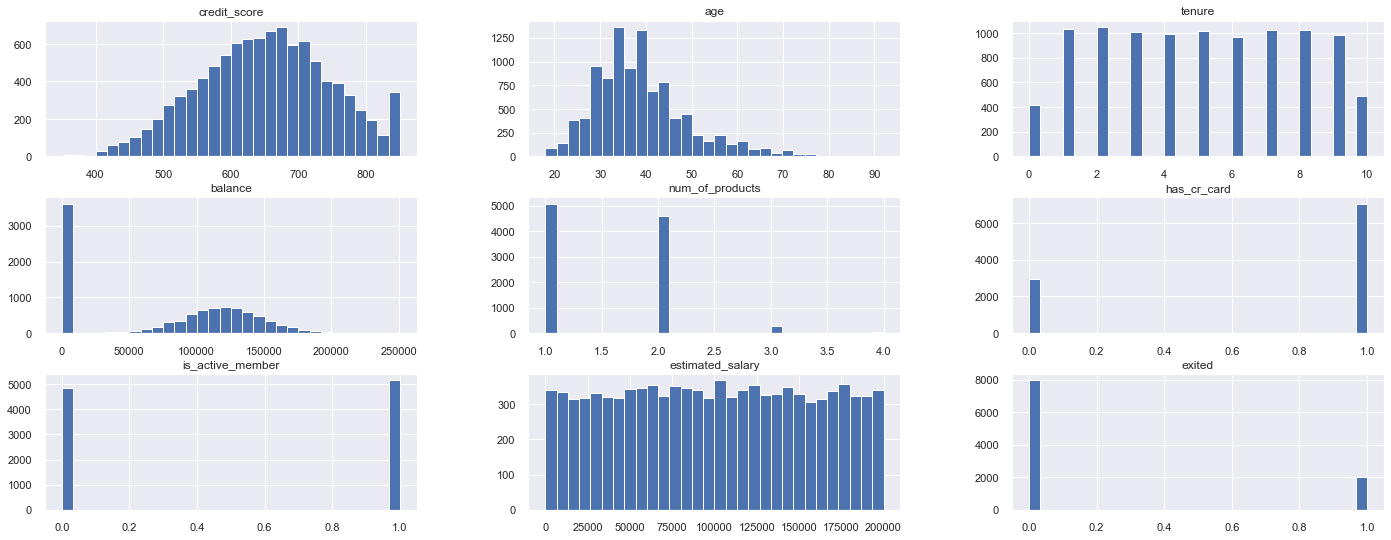

In [77]:
df5 = df4.copy()
df5.hist(bins = 30);

In [78]:
x_train, y_train, x_val, y_val, x_test, y_test = train_valid_test_split(df5, target = 'exited', 
                                                     train_size=0.8, valid_size=0.1, test_size=0.1)

## 5.1 Encoding

In [79]:
# Gender Encoding
x_train['gender'] = x_train['gender'].map({'Male': 0, 'Female': 1})
x_test['gender'] = x_test['gender'].map({'Male': 0, 'Female': 1})
x_val['gender'] = x_val['gender'].map({'Male': 0, 'Female': 1})

#Geography encoding
x_train = pd.get_dummies( x_train, prefix=['geography'], columns=['geography'] )
x_test = pd.get_dummies( x_test, prefix=['geography'], columns=['geography'] )
x_val = pd.get_dummies( x_val, prefix=['geography'], columns=['geography'] )

x_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
1531,600,1,28,6,0.00,2,0,1,52193.23,1,0,0
9391,846,0,61,0,0.00,2,1,1,96202.44,0,0,1
1411,685,1,30,4,84958.60,2,0,1,194343.72,0,1,0
8990,784,0,28,2,109960.06,2,1,1,170829.87,0,1,0
1231,772,0,30,4,78653.05,1,1,0,1790.48,0,0,1


## 5.1 Rescalling

In [80]:
#Defining scalers
rs = RobustScaler()
ss = StandardScaler()
mms = MinMaxScaler()

#Credit Score
x_train['credit_score'] = rs.fit_transform(x_train[['credit_score']].values)
pickle.dump(rs, open('../parameters/credit_score_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['credit_score'] = rs.transform(x_test[['credit_score']].values)
x_val['credit_score'] = rs.transform(x_val[['credit_score']].values)

#Age
x_train['age'] = ss.fit_transform(x_train[['age']].values)
pickle.dump(ss, open('../parameters/age_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['age'] = ss.transform(x_test[['age']].values)
x_val['age'] = ss.transform(x_val[['age']].values)

#Estimated Salary
x_train['estimated_salary'] = rs.fit_transform(x_train[['estimated_salary']].values)
pickle.dump(rs, open('../parameters/estimated_salary_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['estimated_salary'] = rs.transform(x_test[['estimated_salary']].values)
x_val['estimated_salary'] = rs.transform(x_val[['estimated_salary']].values)

#Tenure
x_train['tenure'] = mms.fit_transform(x_train[['tenure']].values)
pickle.dump(mms, open('../parameters/tenure_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['tenure'] = mms.transform(x_test[['tenure']].values)
x_val['tenure'] = mms.transform(x_val[['tenure']].values)

#Balance
x_train['balance'] = rs.fit_transform(x_train[['balance']].values)
pickle.dump(rs, open('../parameters/balance_scaler.pkl', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
x_test['balance'] = rs.transform(x_test[['balance']].values)
x_val['balance'] = rs.transform(x_val[['balance']].values)

x_train.head()

,credit_score,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_France,geography_Germany,geography_Spain
1531,-0.38,1,-1.04,0.60,-0.76,2,0,1,-0.48,1,0,0
9391,1.46,0,2.11,0.00,-0.76,2,1,1,-0.04,0,0,1
1411,0.25,1,-0.85,0.40,-0.09,2,0,1,0.95,0,1,0
8990,0.99,0,-1.04,0.20,0.10,2,1,1,0.72,0,1,0
1231,0.90,0,-0.85,0.40,-0.14,1,1,0,-0.99,0,0,1


# 6.0 Feature Selection

In [81]:
df6 = df5.copy()

In [87]:
categorical_metrics(df4, 'exited')

,absolute,percent %
0,7963,79.63
1,2037,20.37


## 6.1.0. Features Analysis

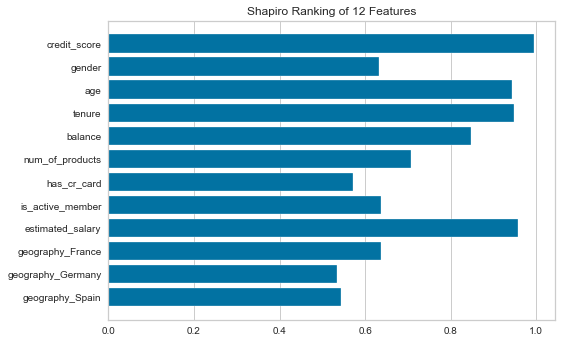

In [52]:
visualizer = Rank1D(algorithm='shapiro')
visualizer.fit(x_train, y_train)
visualizer.transform(x_train)
visualizer.show();

## 6.2 RFE-CV

In [53]:
#preparing for selection
x_train_s = x_train.values
y_train_s = y_train.values.ravel()

Optimal number of features : 9


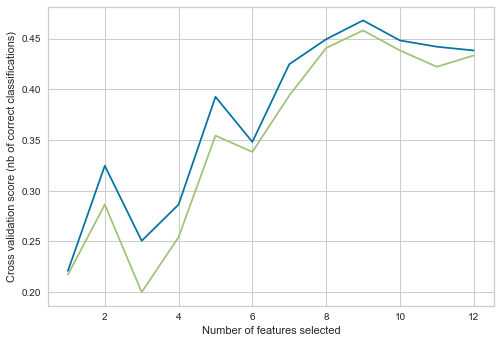

In [61]:
#Create the RFE object and compute a cross-validated score.
et = ExtraTreesClassifier( n_estimators = 100, n_jobs=-1, random_state=42 )

min_features_to_select = 1  # Minimum number of features to consider

rfeet = RFECV(estimator = et, step = 1, cv = StratifiedKFold(2),
              scoring = 'recall',
              min_features_to_select= min_features_to_select)

rfeet.fit(x_train_s, y_train_s)

print("Optimal number of features : %d" % rfeet.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfeet.grid_scores_) + min_features_to_select),
         rfeet.grid_scores_)
plt.show()

In [66]:
cols_selected = rfeet.support_.tolist()
cols_selected_rfecv = x_train.iloc[:, cols_selected].columns.to_list()
cols_selected_rfecv

['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'geography_Germany']

## 6.3 Boruta Feature Selector

In [62]:
#define Classifier
rf = RandomForestClassifier( n_jobs = -1 )

boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( x_train_s, y_train_s )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	7
Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	7
Iteration: 	10 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	7
Iteration: 	11 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	7
Iteration: 	12 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	7
Iteration: 	13 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	7
Iteration: 	14 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	7
Iteration: 	15 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	7
Iteration: 	16 / 100
Confirmed: 	3
Tentative: 	2
Rejected: 	7
Iteration:

# 7.0 Machine Learning Modelling

In [159]:
df7 = df6.copy()

In [84]:
cols_selected = ['credit_score',
 'age',
 'tenure',
 'balance',
 'num_of_products',
 'has_cr_card',
 'is_active_member',
 'estimated_salary',
 'geography_Germany']

x_train = x_train[cols_selected].copy()
x_test = x_test[cols_selected].copy()

## 7.1 Random Forest Classifier

In [103]:
#model definition
model_rf = RandomForestClassifier(max_depth = 2, random_state = 42, class_weight = 'balanced')

#train model
model_rf.fit( x_train, y_train.values.ravel() )

#predict
yhat_rf = model_rf.predict( x_test )

#metrics 
print('Recall: '   + str(recall_score(y_test,yhat_rf)))

Recall: 0.6697674418604651


## 7.2 XGBoost Classifier

In [140]:
# model definition
model_xgb = xgb.XGBClassifier(n_estimators = 7, 
                              eta = 0.01, 
                              max_depth = 5, 
                              subsample = 0.4,
                              use_label_encoder = False,
                              eval_metric = 'aucpr',
                              colsample_bytree = 0.9,
                             scale_pos_weight = 4)

#model training
model_xgb.fit( x_train, y_train.values.ravel() )

# prediction
yhat_xgb = model_xgb.predict( x_test )

#metrics 
print('Recall Score: '   + str(recall_score(y_test,yhat_xgb)))

Recall Score: 0.7395348837209302


In [147]:
xgb_cv = ml_cv_results('XGB', model_xgb, x_train, y_train)
xgb_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
XGB,0.772 +/- 0.012,0.497 +/- 0.018,0.732 +/- 0.026,0.591 +/- 0.015,0.462 +/- 0.021


## 7.3 Logistic Regression

In [141]:
#model definition
lg = LogisticRegression(class_weight='balanced')

#model training
lg.fit(x_train, y_train)

#model prediction
y_pred = lg.predict(x_test)

#model metrics
print('Recall Score: '   + str(recall_score(y_test,y_pred)))

Recall Score: 0.6465116279069767


In [180]:
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(class_weight='balanced'), 
                      x_train, y_train)
lg_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
Logistic Regression,0.699 +/- 0.016,0.379 +/- 0.017,0.681 +/- 0.021,0.487 +/- 0.02,0.306 +/- 0.028


## 7.4 Support Vector Machine

In [124]:
svm = SVC(class_weight='balanced')
svm.fit(x_train, y_train)

y_pred = svm.predict(x_test)

In [126]:
#model metrics
print('Recall Score: '   + str(recall_score(y_test,y_pred)))

Recall Score: 0.6883720930232559


In [149]:
svm_cv = ml_cv_results('SVM', SVC(class_weight='balanced'), x_train, y_train)
svm_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.777 +/- 0.01,0.502 +/- 0.019,0.741 +/- 0.025,0.598 +/- 0.014,0.47 +/- 0.02


# 8.0 Hyperparameter Fine-Tunning

In [160]:
df8 = df7.copy()

In [189]:
# def objective(trial):
    
#     class_weight='balanced'
#     kernel=trial.suggest_categorical('kernel',['rbf','poly','linear','sigmoid'])
#     c=trial.suggest_float("C",0.1,3.0,log=True)
#     gamma=trial.suggest_categorical('gamma',['auto','scale'])
#     degree=trial.suggest_int("degree",1,3,log=True)
#     model =SVC(kernel=kernel,degree=degree,gamma=gamma,C=c,class_weight=class_weight)
#     model.fit(x_train,y_train)
#     yhat = model.predict(x_test)
#     results = recall_score(y_test,yhat)
    
#     return results

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials = 500)

# trial = study.best_trial

# print('Recall: {}'.format(trial.value))
# print("Best hyperparameters: {}".format(trial.params))

## Fine-tuned Model

In [203]:
# Recall: 0.7116279069767442
# Best hyperparameters: {'kernel': 'poly', 'C': 2.137803839911113, 'gamma': 'scale', 'degree': 3}


svm = SVC(random_state=42,
          kernel = 'poly', 
          C = 2.137803839911113, 
          gamma = 'scale', 
          degree = 3, 
          class_weight='balanced',
          probability=True)


svm_cv = ml_cv_results('SVM', svm, x_train, y_train)
y_prob = svm.predict_proba(x_test)
svm_cv

,Balanced Accuracy,Precision,Recall,F1,Kappa
SVM,0.749 +/- 0.021,0.459 +/- 0.027,0.711 +/- 0.032,0.558 +/- 0.028,0.414 +/- 0.039


# 9.0 Churn Analysis

In [204]:
df9 = df8.copy()

## Cumulative Gains Curve

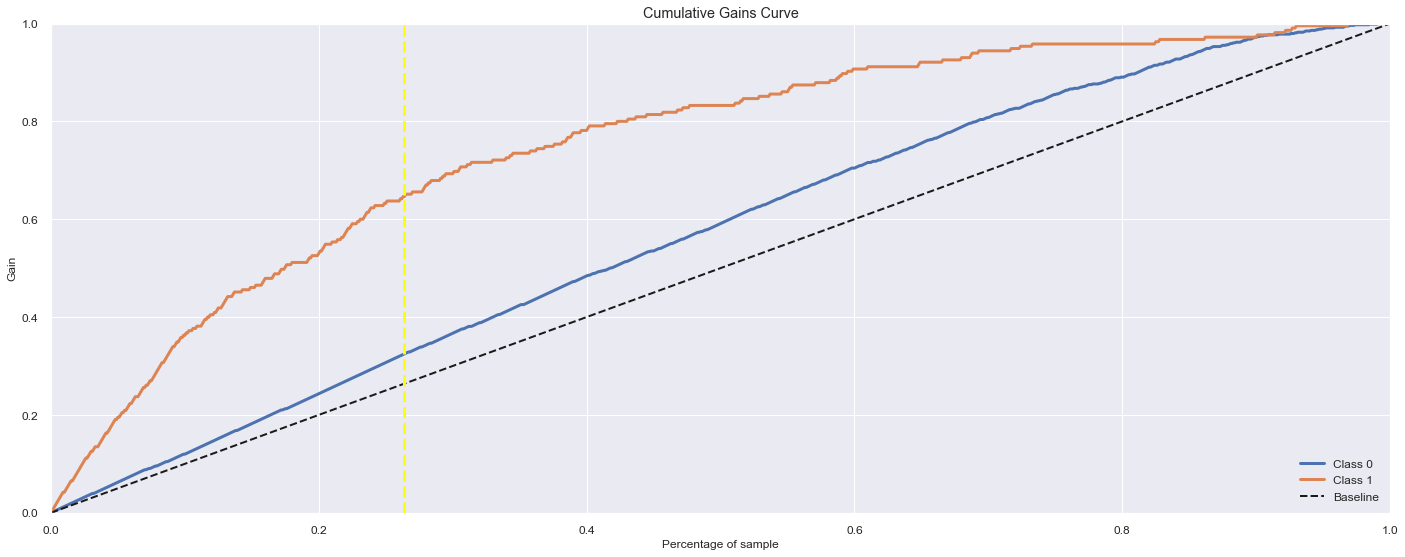

In [205]:
skplt.metrics.plot_cumulative_gain(y_test, y_prob)
plt.axvline(0.2634, 0, 1, color='yellow', ls='--', lw=3)
plt.show(); 

## Recall at K

In [210]:
def recall_at_k( data, k = 100 ):
    # reset index
    data = data.reset_index( drop = True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['exited'].cumsum() / data['exited'].sum()

    return data.loc[k, 'recall_at_k']

In [211]:
data = x_test.copy()

data['exited'] = y_test.copy()
data['score'] = y_prob[:, 1].tolist()
data = data.sort_values('score', ascending=False)

In [213]:
percent_of_dataset = 100 / len(data)
recall_at_100 = recall_at_k(data, k = 100)

print(percent_of_dataset)
print(recall_at_100)

0.1
0.3674418604651163


# 10.0 Business Results

## 1) What is TopBank's current Churn rate? How does it change monthly?

## 2) How does the model perform in classifying customers as churns?

## 3) What is the expected return, in terms of revenue, if the company uses its model to avoid customer churn?

## 4) Which customers would you give the financial incentive to and what would that value be, in order to maximize ROI (Return on Investment). Remembering that the sum of the incentives cannot exceed R$10,000.00

# 11.0 Deploy

## 11.1 Churn Probability Class